# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score   
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import re 
import nltk
from nltk.corpus import stopwords as stopwords_nltk
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [3]:
! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

     |████████████████████████████████| 363 kB 1.7 MB/s eta 0:00:01


In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [6]:
display(df.head())
display(df.info())
display(df.describe())
display(df.shape)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


(159571, 2)

In [7]:
df.duplicated().sum()

0

In [8]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Анализ данных показал, что пустых значений и дубликатов нет. Почти 10% комментариев - токсичные. Перед машинным обучением тексты необходимо предобработать - очистить комментарии от лишних знаков, провести токенизацию (разбить комментарии на отдельные фразы, слова) и лемматизацию текста (привести слова к начальной форме), а также удалить стоп-слова. Проведем эти операции.

In [9]:
#удалим лишние символы
def remove(text):
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return clean_text

df['new_text'] = df['text'].apply(lambda x: remove(x.lower()))
display(df.head())
display(df.tail())

,text,toxic,new_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m s...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember...


,text,toxic,new_text
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for pr...
159569,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...
159570,"""\nAnd ... I really don't think you understand...",0,and i really don t think you understand ...


In [10]:
#удаление стоп-слов

stop_words = set(stopwords_nltk.words('english'))  

def remove_stopwords(text):
    clean_text = [x for x in text.split() if not x in stop_words]  
    return clean_text

df['without_stopwords'] = df['new_text'].apply(lambda x: remove_stopwords(x))
display(df.head())
display(df.tail())

,text,toxic,new_text,without_stopwords
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m s...,"[aww, matches, background, colour, seemingly, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it...,"[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on im...,"[make, real, suggestions, improvement, wondere..."
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember...,"[sir, hero, chance, remember, page]"


,text,toxic,new_text,without_stopwords
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when ...,"[second, time, asking, view, completely, contr..."
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ...,"[ashamed, horrible, thing, put, talk, page]"
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for pr...,"[spitzer, umm, theres, actual, article, prosti..."
159569,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...,"[looks, like, actually, put, speedy, first, ve..."
159570,"""\nAnd ... I really don't think you understand...",0,and i really don t think you understand ...,"[really, think, understand, came, idea, bad, r..."


In [11]:
#проведем лемматизацию
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_words(text):
    clean_text = [lemmatizer.lemmatize(word) for word in text]
    return clean_text

df['lemmas'] = df['without_stopwords'].apply(lambda x: lemmatize_words(x))
display(df.head())
display(df.tail())

,text,toxic,new_text,without_stopwords,lemmas
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, edits, made, username, hardcore,...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m s...,"[aww, matches, background, colour, seemingly, ...","[aww, match, background, colour, seemingly, st..."
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it...,"[hey, man, really, trying, edit, war, guy, con...","[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on im...,"[make, real, suggestions, improvement, wondere...","[make, real, suggestion, improvement, wondered..."
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember...,"[sir, hero, chance, remember, page]","[sir, hero, chance, remember, page]"


,text,toxic,new_text,without_stopwords,lemmas
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when ...,"[second, time, asking, view, completely, contr...","[second, time, asking, view, completely, contr..."
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ...,"[ashamed, horrible, thing, put, talk, page]","[ashamed, horrible, thing, put, talk, page]"
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for pr...,"[spitzer, umm, theres, actual, article, prosti...","[spitzer, umm, there, actual, article, prostit..."
159569,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...,"[looks, like, actually, put, speedy, first, ve...","[look, like, actually, put, speedy, first, ver..."
159570,"""\nAnd ... I really don't think you understand...",0,and i really don t think you understand ...,"[really, think, understand, came, idea, bad, r...","[really, think, understand, came, idea, bad, r..."


In [12]:
#построим облака слов для все комментариев, нейтральных, и токсичных.

words = list(itertools.chain.from_iterable(df['lemmas']))
neutral = df.query('toxic == 0')
neutral_words = list(itertools.chain.from_iterable(neutral['lemmas']))
toxic = df.query('toxic == 1')
toxic_words = list(itertools.chain.from_iterable(toxic['lemmas']))

display(toxic)

,text,toxic,new_text,without_stopwords,lemmas
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work,"[cocksucker, piss, around, work]","[cocksucker, piss, around, work]"
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,hey what is it talk what is it a...,"[hey, talk, exclusive, group, wp, talibans, go...","[hey, talk, exclusive, group, wp, taliban, goo..."
16,"Bye! \n\nDon't look, come or think of comming ...",1,bye don t look come or think of comming ba...,"[bye, look, come, think, comming, back, tosser]","[bye, look, come, think, comming, back, tosser]"
42,You are gay or antisemmitian? \n\nArchangel WH...,1,you are gay or antisemmitian archangel whit...,"[gay, antisemmitian, archangel, white, tiger, ...","[gay, antisemmitian, archangel, white, tiger, ..."
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,fuck your filthy mother in the ass dry,"[fuck, filthy, mother, ass, dry]","[fuck, filthy, mother, as, dry]"
...,...,...,...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1,our previous conversation you fucking sh...,"[previous, conversation, fucking, shit, eating...","[previous, conversation, fucking, shit, eating..."
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,you are a mischievious pubic hair,"[mischievious, pubic, hair]","[mischievious, pubic, hair]"
159541,Your absurd edits \n\nYour absurd edits on gre...,1,your absurd edits your absurd edits on great...,"[absurd, edits, absurd, edits, great, white, s...","[absurd, edits, absurd, edits, great, white, s..."
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1,hey listen don t you ever delete my edi...,"[hey, listen, ever, delete, edits, ever, annoy...","[hey, listen, ever, delete, edits, ever, annoy..."


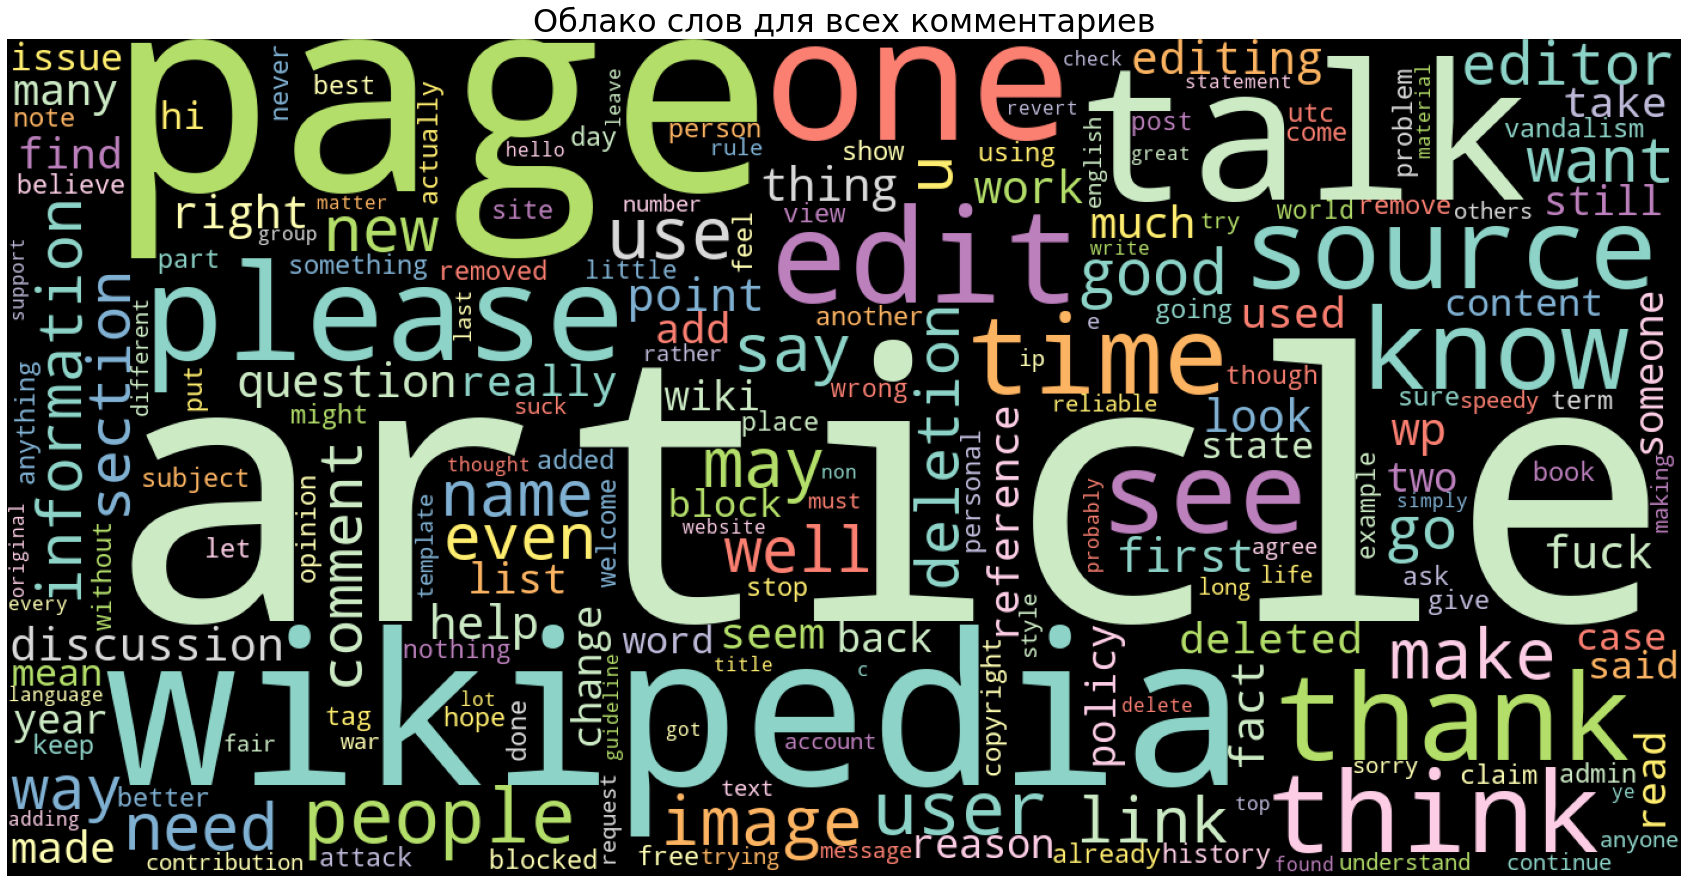

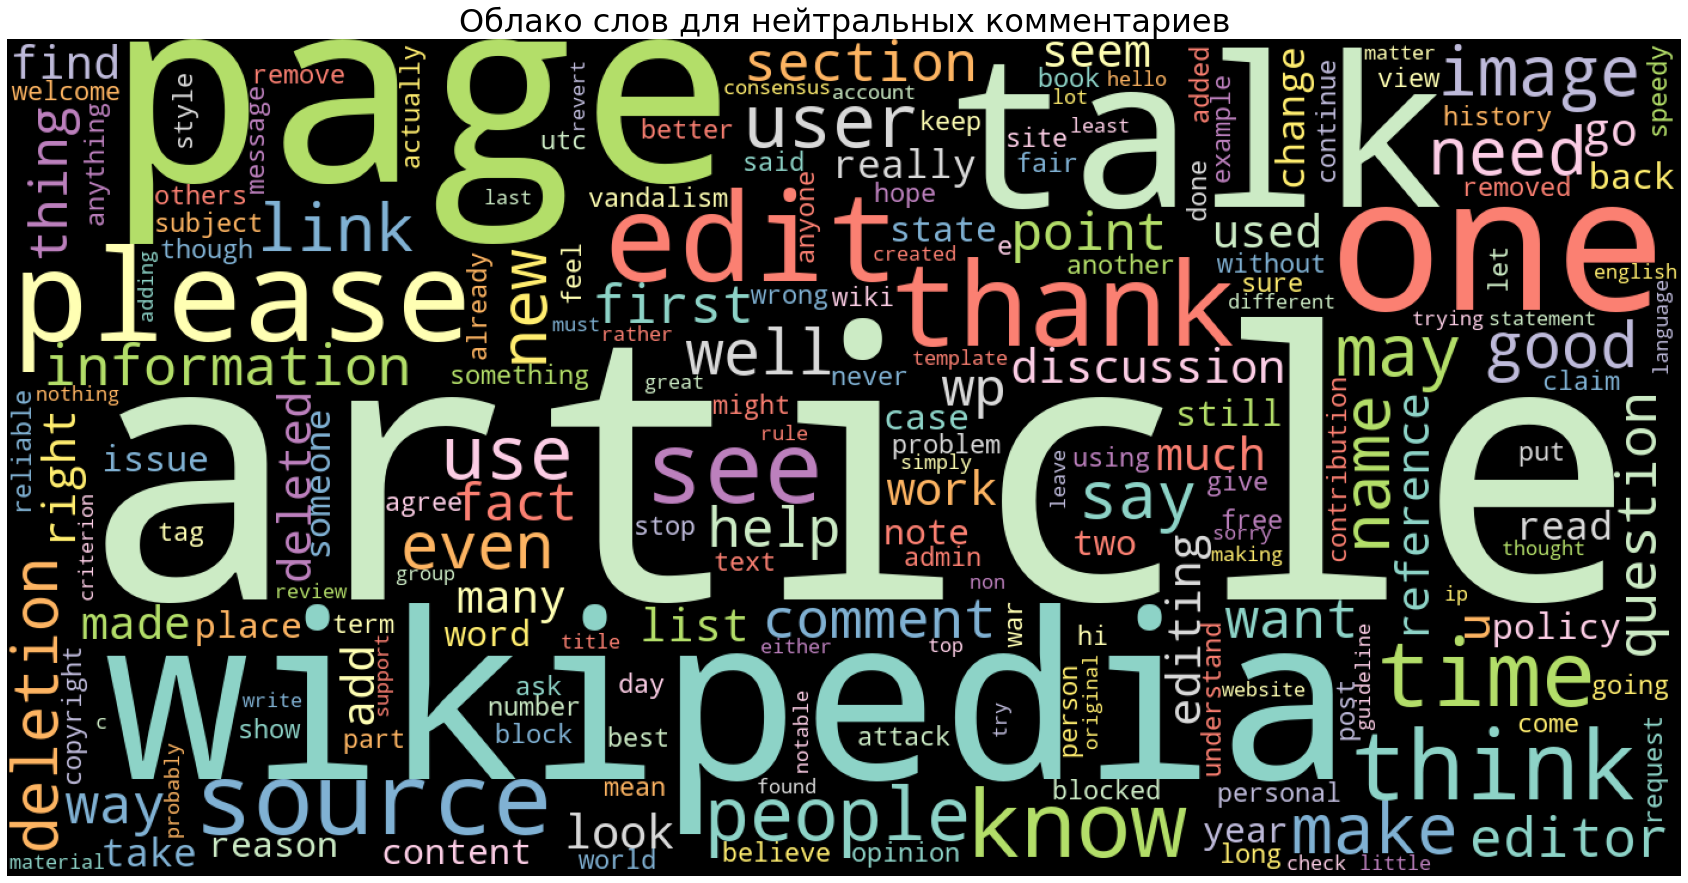

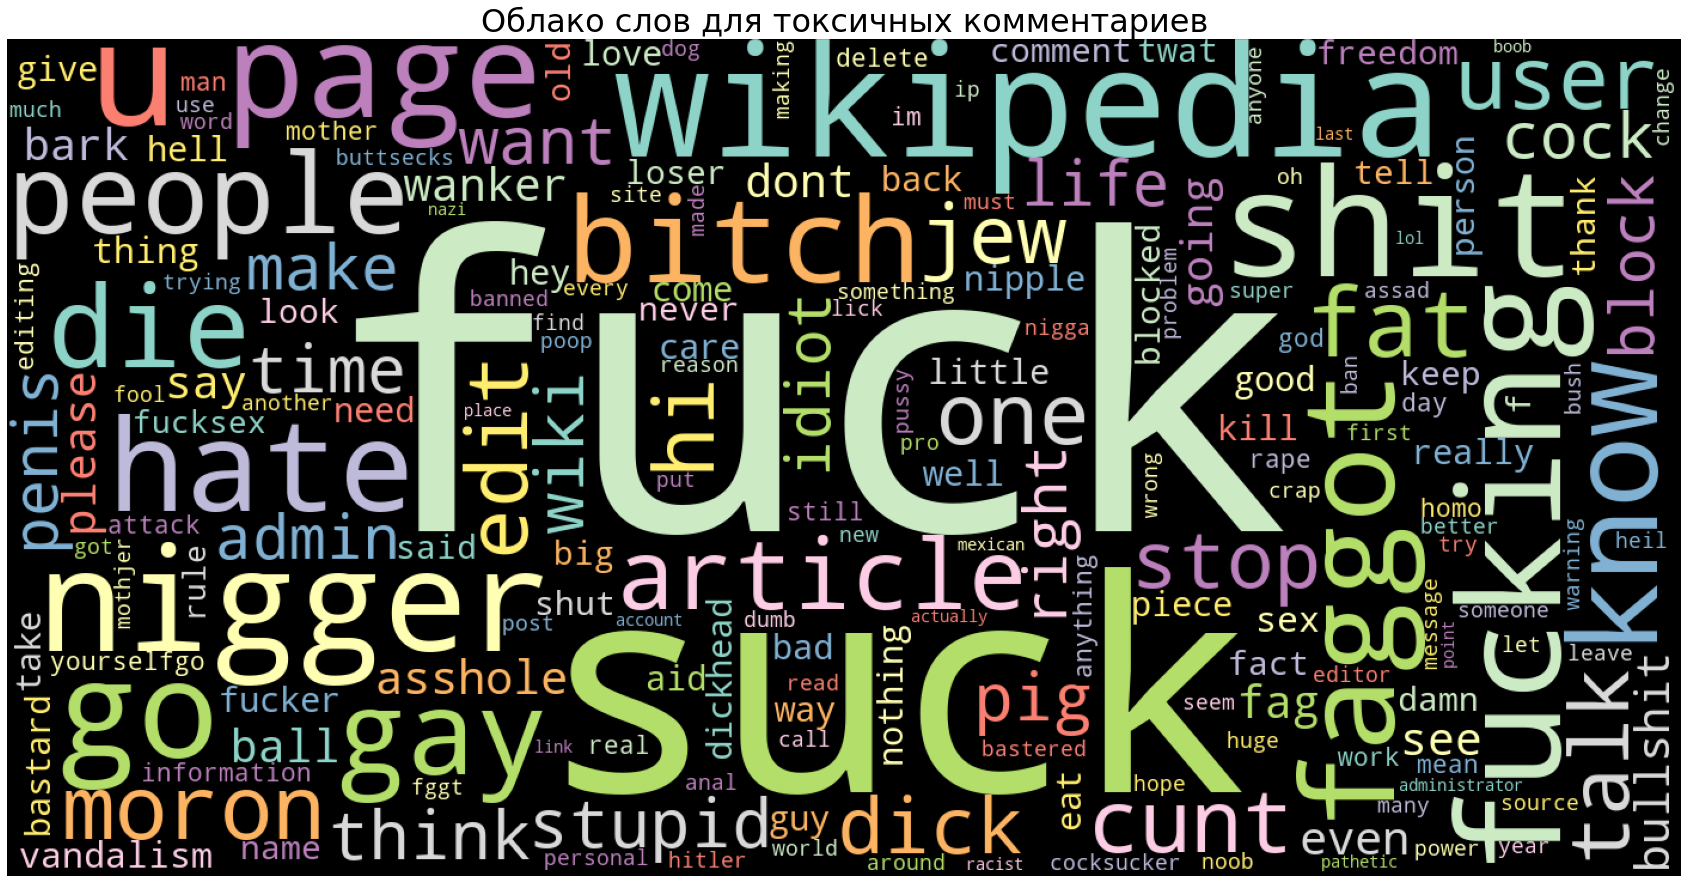

In [13]:
type_of_comments = {'Облако слов для всех комментариев' : words, 
                             'Облако слов для нейтральных комментариев': neutral_words, 
                             'Облако слов для токсичных комментариев': toxic_words}

for key, value in type_of_comments.items():
    
    wordcloud = WordCloud(random_state=123, 
                          width = 1400, 
                          height = 700,
                          background_color='black', 
                          colormap='Set3', 
                          collocations=False, 
                          stopwords = STOPWORDS).generate(' '.join(x for x in value))
    
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis('off')
    plt.title(key, fontsize=32)

Получили список наиболее встречающихся слов в двух видах комментариев.

In [14]:
#Подготовим обучающую и тестовые выюорки

target = df['toxic']
features = df.drop('toxic', axis = 1)

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=12345)
corpus_train = features_train['lemmas'].astype('U')
corpus_test = features_test['lemmas'].astype('U')

count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit(corpus_train)

train_tf_idf = tf_idf.transform(corpus_train)
test_tf_idf = tf_idf.transform(corpus_test)

In [20]:
res = []

In [21]:
def model(model_name):
    model = model_name
    model.fit(train_tf_idf, target_train)
    predicted_test = model.predict(test_tf_idf)
    
    res.append({'Модель': model, 
                'F1': f1_score(target_test, predicted_test)})
    return res

In [22]:
model_lr = model(LogisticRegression(random_state=12345, class_weight='balanced') )

model_dtf = model(DecisionTreeClassifier(random_state=12345, max_depth=5))

model_rfc = model(RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=15, class_weight='balanced'))

In [23]:
res = pd.DataFrame(res)
res['Модель']=['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier']

In [24]:
res

,Модель,F1
0,LogisticRegression,0.752065
1,DecisionTreeClassifier,0.500985
2,RandomForestClassifier,0.372751


In [26]:
#пробуем улучшить модель DecisionTreeClassifier

def f1_scoring(target, predictions):
    f1 = f1_score(target, predictions)
    return f1
F1_score = make_scorer(f1_scoring, greater_is_better=True )

In [27]:
max_depth = [10,100,200,250]

hyperparameter_grid = {
    'max_depth': max_depth,
}


model = DecisionTreeClassifier(random_state = 12345)


random_cv = GridSearchCV(estimator=model,
    param_grid=hyperparameter_grid,
    cv=2, 
    scoring = F1_score,
    n_jobs = -1, verbose = 1, 
    return_train_score = True)


random_cv.fit(train_tf_idf, target_train) 

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1, param_grid={'max_depth': [10, 100, 200, 250]},
             return_train_score=True, scoring=make_scorer(f1_scoring),
             verbose=1)

In [28]:
predicted_test = random_cv.predict(test_tf_idf)
print (f1_score(target_test, predicted_test))

0.7195767195767195


In [29]:
random_cv.best_params_

{'max_depth': 200}

In [30]:
final_results = pd.DataFrame(random_cv.cv_results_)
final_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,7.594491,0.106186,0.053911,0.000176,10,{'max_depth': 10},0.577239,0.586506,0.581872,0.004634,4,0.610131,0.612615,0.611373,0.001242
1,30.119715,0.443208,0.064955,0.006280,100,{'max_depth': 100},0.712247,0.717846,0.715047,0.002800,2,0.879742,0.882450,0.881096,0.001354
2,44.836057,0.170868,0.087800,0.013577,200,{'max_depth': 200},0.713468,0.720309,0.716889,0.003421,1,0.929724,0.928887,0.929305,0.000419
3,52.304954,0.557653,0.081723,0.001306,250,{'max_depth': 250},0.712612,0.713605,0.713109,0.000497,3,0.943705,0.944184,0.943944,0.000239


Показатель вырос, но не настолько сильно, сколько ожидалось.

Попробуем изменить пороговое значение для DecisionTreeClassifier

In [34]:
model = DecisionTreeClassifier(random_state=12345, max_depth=200)
model.fit(train_tf_idf, target_train)
probabilities_test = model.predict_proba(test_tf_idf)
probabilities_one_test = probabilities_test[:, 1]

In [35]:
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid =  probabilities_one_test > threshold 
    f1 = f1_score(target_test, predicted_valid)

    print("Порог = {:.2f} |  F1 = {:.3f}".format(
        threshold, f1)) 

Порог = 0.00 |  F1 = 0.171
Порог = 0.02 |  F1 = 0.210
Порог = 0.04 |  F1 = 0.715
Порог = 0.06 |  F1 = 0.718
Порог = 0.08 |  F1 = 0.718
Порог = 0.10 |  F1 = 0.718
Порог = 0.12 |  F1 = 0.720
Порог = 0.14 |  F1 = 0.720
Порог = 0.16 |  F1 = 0.720
Порог = 0.18 |  F1 = 0.720
Порог = 0.20 |  F1 = 0.720
Порог = 0.22 |  F1 = 0.720
Порог = 0.24 |  F1 = 0.720
Порог = 0.26 |  F1 = 0.720
Порог = 0.28 |  F1 = 0.720
Порог = 0.30 |  F1 = 0.720
Порог = 0.32 |  F1 = 0.720
Порог = 0.34 |  F1 = 0.720
Порог = 0.36 |  F1 = 0.720
Порог = 0.38 |  F1 = 0.720
Порог = 0.40 |  F1 = 0.720
Порог = 0.42 |  F1 = 0.720
Порог = 0.44 |  F1 = 0.720
Порог = 0.46 |  F1 = 0.720
Порог = 0.48 |  F1 = 0.720
Порог = 0.50 |  F1 = 0.720
Порог = 0.52 |  F1 = 0.720
Порог = 0.54 |  F1 = 0.720
Порог = 0.56 |  F1 = 0.720
Порог = 0.58 |  F1 = 0.720
Порог = 0.60 |  F1 = 0.719
Порог = 0.62 |  F1 = 0.719
Порог = 0.64 |  F1 = 0.719
Порог = 0.66 |  F1 = 0.719
Порог = 0.68 |  F1 = 0.719
Порог = 0.70 |  F1 = 0.719
Порог = 0.72 |  F1 = 0.719
П

До необходимого значение 0.75 снова не вышло увеличить. Можно на этом остановиться, так как у нас уже есть необходимое значение F1 у модели LogisticRegression.

## Выводы

Во время предоработки данных мы очистили комментарии от лишних знаков, стоп-слов. Привели слова к леммам и рассчитали наиболее часто встречающиеся слова в зависимости от типа комментария.

Для решения задачи классификации использовались модели LogisticRegression,DecisionTreeClassifier,RandomForestClassifier. Наилучший показатель F1 получился у модели LogisticRegression - 0.752065. Были попытки улучшить F1 для DecisionTreeClassifier, но до нужного значения добраться не удалось. Возможен еще вариант с увеличинием выборок, но данная задача решилась с помощью LogisticRegression, то продолжать пытаться увеличить значение с помощью этого варианта не имеет смысла.